# imports and loading

In [1]:
# !pip install lightning

In [2]:
# %pip install --upgrade ultralytics

In [3]:
import ultralytics
from ultralytics import YOLO
ultralytics.checks()

Ultralytics YOLOv8.0.166 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 14928MiB)
Setup complete ✅ (4 CPUs, 14.6 GB RAM, 36.5/98.2 GB disk)


In [4]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import os
import json
from PIL import Image
from tqdm import tqdm
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import utils
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from torchvision.models import resnet34
from torch import nn
from pytorch_lightning import Trainer
from torchvision.transforms.functional import pad
from torch.utils.data import random_split
import ast
import shutil
import random

In [5]:
import sys
repo_dir = '/home/jupyter/mga'
repo_url = 'https://github.com/roihezkiyahu/mga.git'

if os.path.exists(repo_dir):
    %cd $repo_dir
    !git pull
    %cd 
else:
    !git clone $repo_url

sys.path.append(repo_dir)

from mga.utils.util_funcs import create_dataframe, create_bounding_boxes, sort_yolo_folders, load_bounding_boxes
from mga.plot_functions.mga_plt import plot_w_box_from_path
from mga.data.global_data import outlier_images

/home/jupyter/mga
hint: Pulling without specifying how to reconcile divergent branches is
hint: discouraged. You can squelch this message by running one of the following
hint: commands sometime before your next pull:
hint: 
hint:   git config pull.rebase false  # merge (the default strategy)
hint:   git config pull.rebase true   # rebase
hint:   git config pull.ff only       # fast-forward only
hint: 
hint: You can replace "git config" with "git config --global" to set a default
hint: preference for all repositories. You can also pass --rebase, --no-rebase,
hint: or --ff-only on the command line to override the configured default per
hint: invocation.
Already up to date.
/home/jupyter


### pathing

In [6]:
tr_img = 'train/images'
tr_an  = 'train/annotations'
tr_labels  = 'labels'
train_df_csv = "train_df.csv"

### order the data

In [7]:
sort_yolo_folders(tr_img, tr_labels)

100%|██████████| 3030/3030 [00:00<00:00, 8363.46it/s]


In [8]:
train_df = pd.read_csv(train_df_csv)
# adapt to notebook
train_df["annotation"] = train_df["annotation"].apply(lambda x: x.replace("benetech-making-graphs-accessible/train", "train"))
train_df["image"] = train_df["image"].apply(lambda x: x.replace("benetech-making-graphs-accessible/train", "train"))

### image plotting (validating bboxes)

In [9]:
base_path = os.path.join('dataset','train')
images_path = os.path.join(base_path, 'images')
images_list = os.listdir(images_path) 
img_path = images_list[0]
img_path

'4d84240bcc07.jpg'

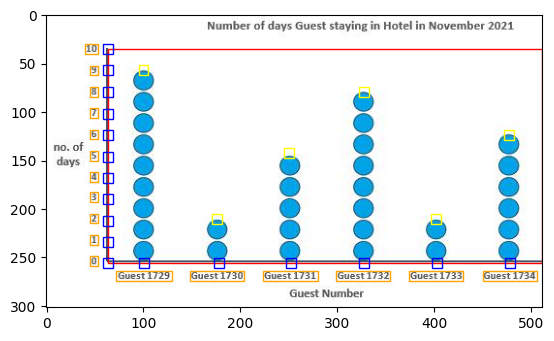

In [10]:
for i in range(1):
    plot_w_box_from_path(i, base_path = os.path.join('dataset','train'))


# YOLO

In [11]:
# Let's create the content for the `dataset.yaml` file

content = """
train: /home/jupyter/dataset/train/images
val: /home/jupyter/dataset/valid/images
test: /home/jupyter/dataset/test/images

nc: 8
names: ["plot", "x_tick", "y_tick", "scatter_point", "bar", "dot_point", "line_point", "tick_label"]
"""

# Now, we'll save the content to a `dataset.yaml` file
file_path = "dataset.yaml"

with open(file_path, 'w') as file:
    file.write(content)

file_path

'dataset.yaml'

In [ ]:
model = YOLO('yolov8l.yaml')

acc_device = "cuda" if torch.cuda.is_available() else "cpu"
batch = 18
epochs = 100
optimizer = 'Adam'
lr0 = 1e-4
label_smoothing = 0
cache = False
imgsz = 640 # original size is 640, want to check what will 480 cause
augmentations = {
    "hsv_h": 0.1,
    "hsv_s": 0.5,
    "hsv_v": 0.5,
    "translate": 0.1,
    "scale": 0.1,
    "fliplr": 0,
    "mosaic": 0,
    "close_mosaic": 0
}

project = "/home/jupyter/full_data"
name = "/home/jupyter/full_data/large_img640_batch_16_lr1e4"
last_weight = os.path.join(name, 'weights/last.pt')

if os.path.exists(last_weight):
    model = YOLO(last_weight)

res = model.train(data="dataset.yaml", epochs=epochs, imgsz = imgsz, resume=True,
            batch=batch, cache=cache, device=acc_device, lr0=lr0, optimizer=optimizer, label_smoothing=label_smoothing,
                  project = project, name = name, **augmentations)


                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  3    279808  ultralytics.nn.modules.block.C2f             [128, 128, 3, True]           
  3                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  4                  -1  6   2101248  ultralytics.nn.modules.block.C2f             [256, 256, 6, True]           
  5                  -1  1   1180672  ultralytics.nn.modules.conv.Conv             [256, 512, 3, 2]              
  6                  -1  6   8396800  ultralytics.nn.modules.block.C2f             [512, 512, 6, True]           
  7                  -1  1   2360320  ultralytics.nn.modules.conv.Conv             [512

In [ ]:
model = YOLO('yolov8s.yaml')

acc_device = "cuda" if torch.cuda.is_available() else "cpu"
batch = 32
epochs = 80
optimizer = 'Adam'
lr0 = 1e-5
label_smoothing = 0
cache = False
imgsz = 640 # original size is 640, want to check what will 480 cause
augmentations = {
    "hsv_h": 0.1,
    "hsv_s": 0.5,
    "hsv_v": 0.5,
    "translate": 0.1,
    "scale": 0.1,
    "fliplr": 0,
    "mosaic": 0,
    "close_mosaic": 0
}

project = "/home/jupyter/full_data"
name = "/home/jupyter/full_data/img640_batch_32_lr1e4"
last_weight = os.path.join(name, 'weights/last.pt')

if os.path.exists(last_weight):
    model = YOLO(last_weight)

res = model.train(data="dataset.yaml", epochs=epochs, imgsz = imgsz, resume=True,
            batch=batch, cache=cache, device=acc_device, lr0=lr0, optimizer=optimizer, label_smoothing=label_smoothing,
                  project = project, name = name, **augmentations)

In [ ]:
def get_random_image(dir_path):
    images = [os.path.join(dir_path, "images", f) for f in os.listdir(os.path.join(dir_path, "images")) if f.endswith('.jpg')]
    return random.choice(images)

train_img_name = get_random_image(os.path.join(base_dir, 'train'))
valid_img_name = get_random_image(os.path.join(base_dir, 'valid'))
test_img_name = get_random_image(os.path.join(base_dir, 'test'))

In [ ]:
train_img_name = get_random_image(os.path.join(base_dir, 'train'))
valid_img_name = get_random_image(os.path.join(base_dir, 'valid'))
test_img_name = get_random_image(os.path.join(base_dir, 'test'))
results = model(source=test_img_name, augment=False)
res_plotted = results[0].plot()
plt.imshow(res_plotted)
plt.show()

In [ ]:
# !yolo task=detect mode=train model=yolov8s.yaml data=dataset.yaml

In [ ]:
stop